In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix
from starter_code import construct_system

In [2]:
# Can Dimensions [m]
h = 0.12
r = 0.03
d = 2*r

kfun = lambda r, z : 0.58 #[W m-1 K-1] @ 10 C
qppp = lambda r, z : 0 # no heat gen in can

k = kfun(0,0)
mu = 17.916e-4 # {Pa*s}
rho = 1000 # ~{kg/m^3}
w = np.pi*d # {m/s}
c_p = 4.22 * 1000 # {J/kg*K}

Re = rho * w * d / mu
Pr = c_p * mu / k
Nu = 0.133 * Re**(2/3) * Pr**(1/3)
HTC = Nu*k/d

T_oo = 0 # {C}

In [3]:
N_r = 30
N_z = 120

r_edge = np.linspace(0, r, N_r+1)
z_edge = np.linspace(0, h, N_z+1)

r_center = (r_edge[:-1]+r_edge[1:])/2
z_center = z_edge[:-1]+z_edge[1:]/2

In [4]:
BC_z = ('robin', HTC, T_oo)
BC_r_top = ('robin', HTC, T_oo)
BC_r_bottom = ('robin', HTC, T_oo)

In [5]:
A, b = construct_system(r_center, z_center, kfun, qppp,
                        BC_z, BC_r_top, BC_r_bottom)
A_spc = csr_matrix(A)

In [6]:
def T_prime(t, T, A, b, rho, c_p):
    return (b - A@T)/rho/c_p

In [7]:
T0 = 35 * np.ones(A.shape[0]) # {deg C}

t_initial = 0
t_final = 900
t_eval = np.linspace(t_initial, t_final, 100) # times at which we want the solution; otherwise, the solver selects!

sol = solve_ivp(T_prime, [t_initial, t_final], T0, 
                args=(A_spc, b, rho, c_p),
                t_eval=t_eval,
                method='BDF')

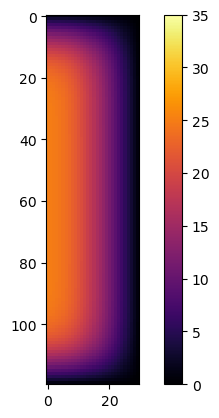

In [8]:
i=99
plt.imshow(sol.y[:,i].reshape((N_z, N_r)), cmap="inferno",vmin=0,vmax=np.max(sol.y)); cbar = plt.colorbar();

In [9]:
r_weights = np.array([r_edge[-(i+1)]**2 - r_edge[-(i+2)]**2 for i in range(N_r)])
r_weights_norm = np.flip(r_weights/sum(r_weights))
T_bar = np.zeros_like(t_eval)
for i in range(len(T_bar)):
    T_bar[i] = sum(sum(sol.y[:,i].reshape((N_z, N_r))*r_weights_norm))/N_z
T_bar

array([35.        , 32.46856997, 31.09170184, 30.06199684, 29.21116868,
       28.47403881, 27.81662676, 27.22005264, 26.67121081, 26.16108991,
       25.68346911, 25.23404879, 24.80847762, 24.40389338, 24.01798829,
       23.64855801, 23.29418302, 22.95378723, 22.62569147, 22.30900378,
       22.00285602, 21.70621064, 21.41875885, 21.13950756, 20.86830137,
       20.60438553, 20.34761938, 20.09747279, 19.85338844, 19.61507787,
       19.38253162, 19.15516111, 18.93259938, 18.71501383, 18.5019838 ,
       18.29321246, 18.08859301, 17.88808873, 17.69139156, 17.4983147 ,
       17.30903102, 17.12317391, 16.94058185, 16.76109333, 16.58454682,
       16.41118195, 16.24068901, 16.07292355, 15.90776248, 15.74508269,
       15.58506645, 15.42752639, 15.2723291 , 15.11938477, 14.96860359,
       14.82007716, 14.67371338, 14.52939919, 14.38706755, 14.24665144,
       14.1082375 , 13.97176268, 13.8371049 , 13.70420847, 13.57301772,
       13.44347695, 13.31553049, 13.18918847, 13.06457629, 12.94

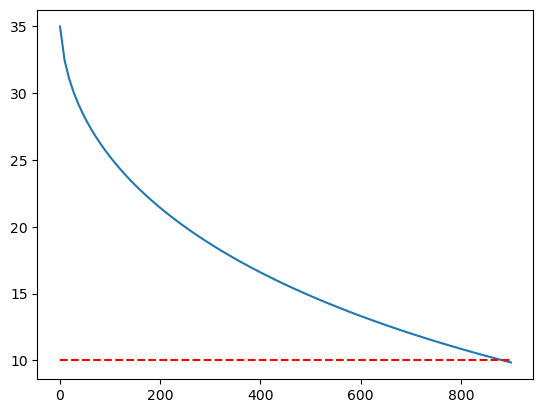

In [10]:
plt.plot(t_eval,T_bar)
plt.plot(t_eval,10*np.ones_like(t_eval),'r--')

In [12]:
def Cool_can(N_r, t_final, t_initial, T0=None):
    """
    Parameters that are unchanged are set internally
    User control can be implemented as needed
    
    
    """
    def T_prime(t, T, A, b, rho, c_p):
        return (b - A@T)/rho/c_p
    
    h = 0.12
    r = 0.03
    d = 2*r

    kfun = lambda r, z : 0.58 #[W m-1 K-1] @ 10 C
    qppp = lambda r, z : 0 # no heat gen in can
    
    k = kfun(0,0)
    mu = 17.916e-4 # {Pa*s}
    rho = 1000 # ~{kg/m^3}
    w = np.pi*d # {m/s}
    c_p = 4.22 * 1000 # {J/kg*K}
    
    Re = rho * w * d / mu
    Pr = c_p * mu / k
    Nu = 0.133 * Re**(2/3) * Pr**(1/3)
    HTC = Nu*k/d
    T_oo = 0 # {C}
    if T0 == None: T0 = 35

    #set Boundary Conditions
    BC_z = ('robin', HTC, T_oo)
    BC_r_top = ('robin', HTC, T_oo)
    BC_r_bottom = ('robin', HTC, T_oo)

    #discritization
    #N_r = 30
    N_z = (h/r)*N_r #equal delta in h and r directions

    r_edge = np.linspace(0, r, N_r+1)
    z_edge = np.linspace(0, h, N_z+1)

    r_center = (r_edge[:-1]+r_edge[1:])/2
    z_center = z_edge[:-1]+z_edge[1:]/2

    A, b = construct_system(r_center, z_center, kfun, qppp,
                        BC_z, BC_r_top, BC_r_bottom)
    A_spc = csr_matrix(A)

    if type(T0) == int: T0 = T0 * np.ones(A.shape[0]) # {deg C}
    elif type(T0) == np.ndarray: None
    else: raise "Missing Initial Temperature Map"

    t_eval = np.linspace(t_initial, t_final, 100) # times at which we want the solution; otherwise, the solver selects!
    
    sol = solve_ivp(T_prime, [t_initial, t_final], T0, 
                    args=(A_spc, b, rho, c_p),
                    t_eval=t_eval,
                    method='BDF')

    
    r_weights = np.array([r_edge[-(i+1)]**2 - r_edge[-(i+2)]**2 for i in range(N_r)])
    r_weights_norm = np.flip(r_weights/sum(r_weights))
    T_bar = np.zeros_like(t_eval)
    for i in range(len(T_bar)):
        T_bar[i] = sum(sum(sol.y[:,i].reshape((N_z, N_r))*r_weights_norm))/N_z

    return t_final, t_initial, T_bar, sol.y[:,-1].reshape((N_z, N_r))
    

In [ ]:
def Convergance_test(N_r, t_final, t_initial, T0=None):
    

In [ ]:
t=np.array(53)
if type(t) == np.ndarray:print(t)

In [ ]:
type(t)